In [1]:
import numpy as np
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import matplotlib.colors as clr
import matplotlib.cm as cmx
from mpl_toolkits import mplot3d
from matplotlib.patches import Circle

In [2]:
np.random.seed(42)

# Schliebs

In [3]:
N = 200
Ngx = 5
Ngy = 5
Ngz = 8
f = 0.2
AoC = [0.3, 0.2, 0.5, 0.1]
DoC = 0.2
w_min = -1
w_max = 1

## Topology

In [4]:
neurons = np.arange(N)    
types = np.random.choice([-1, 1], size=N, p=[f, 1-f])
reservoir = np.array(list(zip(neurons, types)))   
grid = reservoir.reshape((Ngx, Ngy, Ngz, -1))

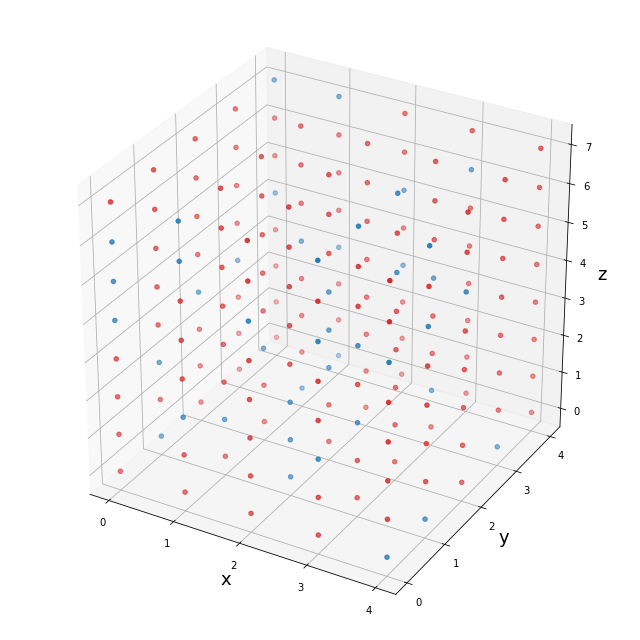

In [5]:
fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection='3d')
norm  = clr.Normalize(vmin=0, vmax=9)
smap = cmx.ScalarMappable(norm=norm, cmap='tab10')
mx, my, mz = np.meshgrid(np.arange(Ngx), np.arange(Ngy), np.arange(Ngz))
colors = np.zeros((Ngx, Ngy, Ngz))
exc = np.array(list(zip(*np.where(grid[:,:,:,1]==1))))
inh = np.array(list(zip(*np.where(grid[:,:,:,1]==-1))))
colors[exc[:,0], exc[:,1], exc[:,2]] = 3
colors[inh[:,0], inh[:,1], inh[:,2]] = 0
ax.set_xlabel("x", fontsize=18)
ax.set_ylabel("y", fontsize=18)
ax.set_zlabel("z", fontsize=18)
ax.set_xticks(np.arange(Ngx))
ax.set_yticks(np.arange(Ngy))
ax.set_zticks(np.arange(Ngz))
ax.scatter3D(mx, my, mz, c=smap.to_rgba(colors.flatten()))
plt.tight_layout()
#plt.savefig("images/lattice-schliebs.pdf", bbox_inches="tight")

## Connectivity

In [6]:
def _pAB(a, b, AoC, DoC):
    if a[3]==1 and b[3]==1:
        C = AoC[0]
    elif a[3]==1 and b[3]==-1:
        C = AoC[1]
    elif a[3]==-1 and b[3]==1:
        C = AoC[2]
    elif a[3]==-1 and b[3]==-1:
        C = AoC[3]
    return C*np.exp(-0.5*(np.linalg.norm(a[:3]-b[:3])/DoC)**2)

In [7]:
def _coords(n, grid):
    x = np.zeros(4, dtype=np.float)
    c = np.array(list(zip(*np.where(grid[:,:,:,0]==n)))[0])
    for (i, dim) in enumerate(grid.shape[:-1]):
        x[i] = c[i]/dim
    x[-1] = grid[c[0], c[1], c[2], 1]
    return x

In [8]:
def _norm(a, AoC, Doc, grid):
    norm = 0
    for n in neurons:
        b = _coords(n, grid)
        norm += _pAB(a, b, AoC, DoC)
    return norm

In [9]:
C = np.zeros((N, N))
for n in neurons:
    a = _coords(n, grid)
    norm = 1.0#_norm(a, AoC, DoC, grid) #np.sqrt(2*np.pi*DoC**2)
    for m in neurons:
        b = _coords(m, grid)
        p = _pAB(a, b, AoC, DoC)
        C[n, m] = p/norm

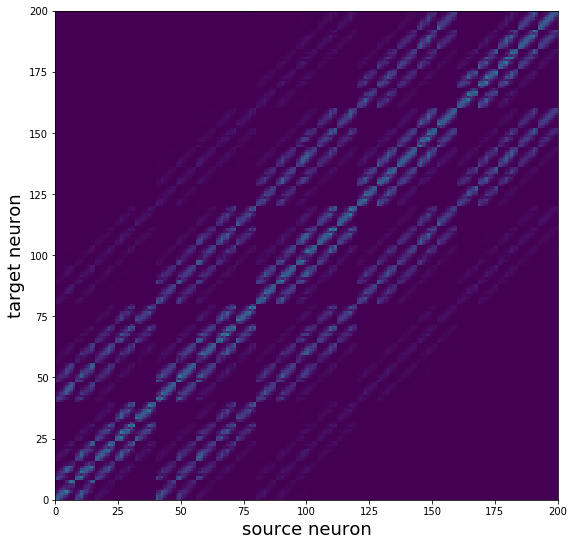

In [10]:
fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(C.T, interpolation='nearest', origin='low', aspect='auto', \
                extent=[0, N, 0, N], cmap='viridis', vmin=0, vmax=1)
#ax_cbar1 = fig.add_axes([1, 0.12, 0.05, 0.76])
#cb = plt.colorbar(im, cax=ax_cbar1, orientation='vertical')
#cb.set_label(label="weight", fontsize=18)
ax.set_xlabel("source neuron", fontsize=18)
ax.set_ylabel("target neuron", fontsize=18)
#ax.set_title("Probability of connection")
plt.savefig("images/connectivity-schliebs.pdf", bbox_inches="tight")

## Weight matrix

In [11]:
def _wAB(ta, tb, w_min, w_max):
    if ta==-1 and tb==1:
        w = np.random.uniform(low=w_min, high=0.0)
    else:
        w = np.random.uniform(low=1e-3, high=w_max+1e-3)
    return w

In [12]:
def _wAB(a, b, loc_wResE, scale_wResE, loc_wResI, scale_wResI):
    if a[3]==-1 and b[3]==1:
        w = 1
        while w>0:
            w = np.random.normal(loc_wResI, scale_wResI)
    else:
        w = -1
        while w<0:
            w = np.random.normal(loc_wResE, scale_wResE)
    return w

In [13]:
W = np.zeros((N, N))
for n in neurons:
    a = _coords(n, grid)
    for m in neurons:
        b = _coords(m, grid)
        r = np.random.uniform()
        if r<C[n, m]:
            W[n, m] = _wAB(a, b, 1, 0.5, -1, 0.5) #_wAB(a[3], b[3], w_min, w_max)

Text(0, 0.5, 'target neuron')

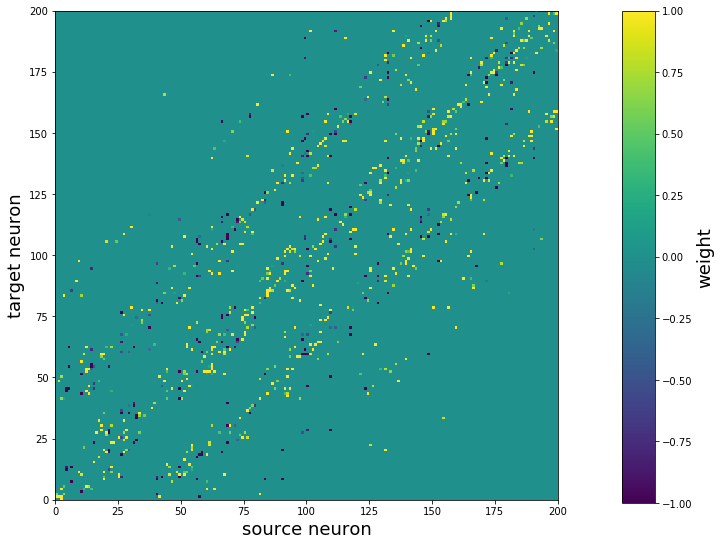

In [14]:
fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(W.T, interpolation='nearest', origin='low', aspect='auto', \
                extent=[0, N, 0, N], cmap='viridis', vmin=w_min, vmax=w_max)
ax_cbar1 = fig.add_axes([1, 0.12, 0.05, 0.76])
cb = plt.colorbar(im, cax=ax_cbar1, orientation='vertical')
cb.set_label(label="weight", fontsize=18)
ax.set_xlabel("source neuron", fontsize=18)
ax.set_ylabel("target neuron", fontsize=18)
#ax.set_title("Weight matrix")

## Stability

In [15]:
ew, ev = eigs(W, k=N-2)

In [16]:
centroid = [np.sum(ew.real)/len(ew.real), np.sum(ew.imag)/len(ew.imag)]

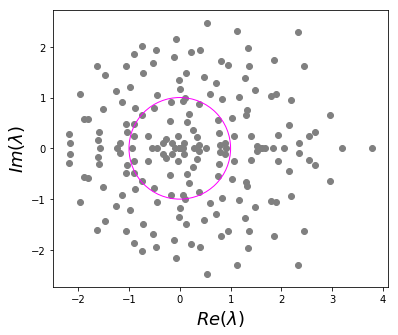

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
#ax.set_aspect('equal')
ax.scatter(ew.real, ew.imag, color="gray")
#ax.axvline(1.0, linestyle="dashed", color="magenta")
#ax.scatter(centroid[0], centroid[1], color="red")
ax.add_patch(plt.Circle((0, 0), radius=1, facecolor="none", edgecolor="magenta"))
ax.set_xlabel(r"$Re(\lambda)$", fontsize=18)
ax.set_ylabel(r"$Im(\lambda)$", fontsize=18)
ax.set_aspect("equal")

## Input balance

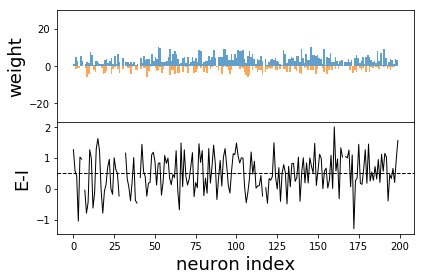

In [18]:
wE = np.array([W[W[:, n]>0, n].sum() for n in neurons])
wI = np.array([W[W[:, n]<0, n].sum() for n in neurons])
in_degree = np.array([len(W[W[:, n]!=0, n]) for n in neurons])
in_degree = np.ma.masked_where(in_degree==0, in_degree)
fig = plt.figure(figsize=(6, 4))
ib = np.ma.divide(wE+wI, in_degree)
grid = grs.GridSpec(2, 1, wspace=0.0, hspace=0.0)
ax1 = plt.Subplot(fig, grid[0])
ax1.bar(neurons, wE, width=1, alpha=0.7, label="excitatory")
ax1.bar(neurons, wI, width=1, alpha=0.7, label="inhibitory")
ax1.set_ylabel("weight", fontsize=18)
ax1.set_ylim((-30, 30))
ax2 = plt.Subplot(fig, grid[1])
ax2.plot(neurons, ib, color="k", linewidth=1, label="input balance")
ax2.axhline(ib.mean(), color="k", linewidth=1, linestyle="dashed", label="mean ib")
ax2.set_xlabel("neuron index", fontsize=18)
ax2.set_ylabel("E-I", fontsize=18)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
#plt.ylim((-35, 35))
#plt.legend(loc="best")
plt.tight_layout()
plt.savefig("images/ib-schliebs.pdf", bbox_inches="tight")

# Hennequin

In [19]:
N = 200
M = N//2
Ngx = 10
Ngy = 10
pE_local = 0.5
pI_local = 1.0
k = 3
DoC = 0.2

## Topology

In [20]:
neurons = np.arange(N)
grid = neurons.reshape((2, Ngx, Ngy))

Text(0.5, 0, 'x')

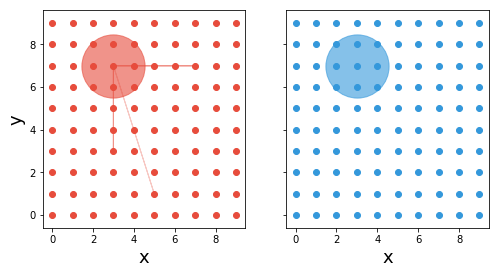

In [21]:
mx, my = np.meshgrid(np.arange(Ngx), np.arange(Ngy))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax1.scatter(mx, my, color="#e74c3c")
ax2.scatter(mx, my, color="#3498db")
ax1.scatter(3, 7, s=4000, c="#e74c3c", edgecolor="#e74c3c", marker='o', alpha=0.6)
ax2.scatter(3, 7, s=4000, c="#3498db", edgecolor="#3498db", marker='o', alpha=0.6)
ax1.arrow(3, 7, 0, -4, color="#e74c3c", alpha=0.6)
ax1.arrow(3, 7, 2, -6, color="#e74c3c", alpha=0.3)
ax1.arrow(3, 7, 4, 0, color="#e74c3c", alpha=0.6)
ax1.set_xlabel("x", fontsize=18)
ax1.set_ylabel("y", fontsize=18)
#ax1.set_title("excitatory", fontsize=18)
ax2.set_xlabel("x", fontsize=18)
#ax2.set_title("inhibitory", fontsize=18)
#plt.savefig("images/lattice-hennequin.pdf", bbobx_inches="tight")

## Connectivity

In [22]:
def _pAB(a, b, p_local, k, DoC):
    l = list(zip(np.random.choice(np.arange(Ngx)/Ngx, size=3), np.random.choice(np.arange(Ngy)/Ngy, size=3)))
    long_range_sum = 0
    for i in range(k):
        long_range_sum += np.exp(-0.5*(np.linalg.norm(a-l[i])/DoC)**2)
    p = p_local*np.exp(-0.5*(np.linalg.norm(a-b)/DoC)**2)+(1-p_local)*long_range_sum/k
    return p

In [23]:
def _coords(n, grid):
    x = np.zeros(2, dtype=np.float)
    c = np.array(list(zip(*np.where(grid==n)))[0])
    for (i, dim) in enumerate(grid.shape[1:]):
        x[i] = c[i+1]/dim
    return x

In [24]:
def _norm(a, DoC, grid):
    norm = 0
    for n in range(N):
        b = _coords(n, grid)
        norm += np.exp(-0.5*(np.linalg.norm(a-b)/DoC)**2)
    return norm

In [25]:
C = np.zeros((N, N))
for n in neurons:
    if n<M:
        p_local = pE_local
    else:
        p_local = pI_local
    a = _coords(n, grid)
    norm = 1.0#_norm(a, DoC, grid) #np.sqrt(2*np.pi*DoC**2)
    for m in neurons:
        b = _coords(m, grid)
        p = _pAB(a, b, p_local, k, DoC)
        C[n, m] = p/norm

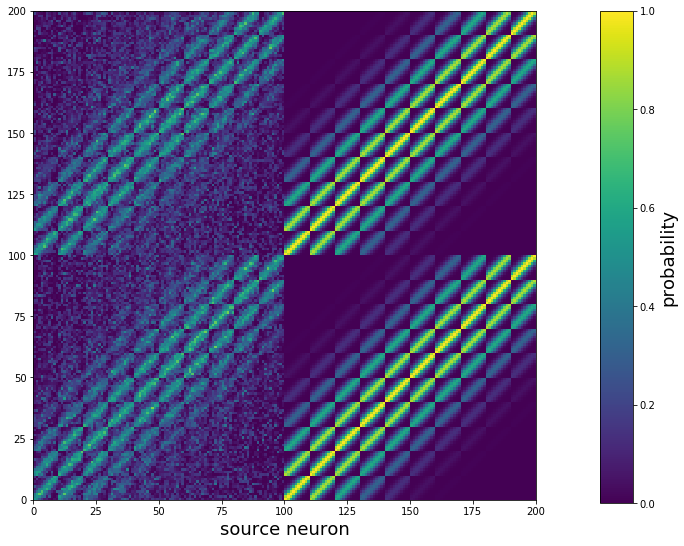

In [26]:
fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(C.T, interpolation='nearest', origin='low', aspect='auto', \
                extent=[0, N, 0, N], cmap='viridis', vmin=0, vmax=C.max())
ax_cbar1 = fig.add_axes([1, 0.12, 0.05, 0.76])
cb = plt.colorbar(im, cax=ax_cbar1, orientation='vertical')
cb.set_label(label="probability", fontsize=18)
ax.set_xlabel("source neuron", fontsize=18)
#ax.set_ylabel("target neuron", fontsize=18)
#ax.set_title("Probability of connection")
plt.savefig("images/connectivity-hennequin.pdf", bbox_inches="tight")

## Weight matrix

In [27]:
def _wAB(ta, w_min, w_max):
    if ta==-1:
        w = np.random.uniform(low=w_min, high=0.0)
    else:
        w = np.random.uniform(low=1e-3, high=w_max+1e-3)
    return w

In [28]:
def _wAB(ta, loc_E, scale_E, loc_I, scale_I):
    if ta==-1:
        w = 1
        while w>0:
            w = np.random.normal(loc_I, scale_I)
    else:
        w = -1
        while w<0:
            w = np.random.normal(loc_E, scale_E)
    return w

In [29]:
W = np.zeros((N, N))
for n in neurons:
    if n<M:
        ta = 1
    else:
        ta = -1
    for m in neurons:
        r = np.random.uniform()
        if r<C[n, m]:
            W[n, m] = _wAB(ta, 1, 0.5, -1, 0.5) # _wAB(ta, w_min, w_max)

Text(0, 0.5, 'target neuron')

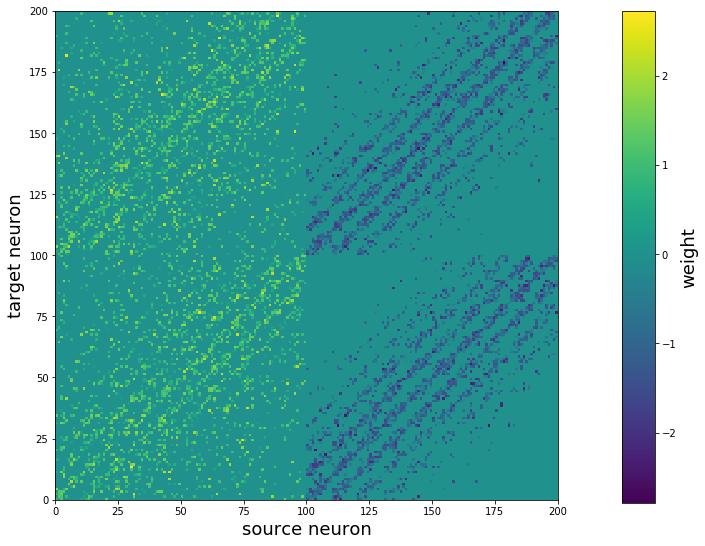

In [30]:
fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(W.T, interpolation='nearest', origin='low', aspect='auto', \
                extent=[0, N, 0, N], cmap='viridis', vmin=W.min(), vmax=W.max())
ax_cbar1 = fig.add_axes([1, 0.12, 0.05, 0.76])
cb = plt.colorbar(im, cax=ax_cbar1, orientation='vertical')
cb.set_label(label="weight", fontsize=18)
ax.set_xlabel("source neuron", fontsize=18)
ax.set_ylabel("target neuron", fontsize=18)
#ax.set_title("Weight matrix")

## Stability

In [31]:
ew, ev = eigs(W, k=N-2)

In [32]:
centroid = [np.sum(ew.real)/len(ew.real), np.sum(ew.imag)/len(ew.imag)]

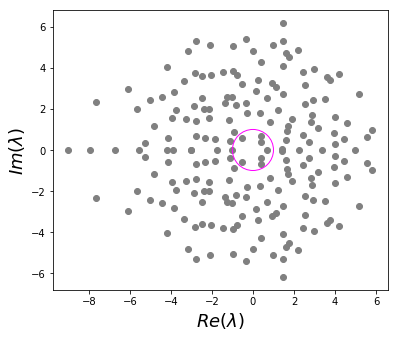

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
#ax.set_aspect('equal')
ax.scatter(ew.real, ew.imag, color="gray")
#ax.axvline(1.0, linestyle="dashed", color="magenta")
#ax.scatter(centroid[0], centroid[1], color="red")
ax.add_patch(plt.Circle((0, 0), radius=1, facecolor="none", edgecolor="magenta"))
ax.set_xlabel(r"$Re(\lambda)$", fontsize=18)
ax.set_ylabel(r"$Im(\lambda)$", fontsize=18)
ax.set_aspect("equal")

## Input balance

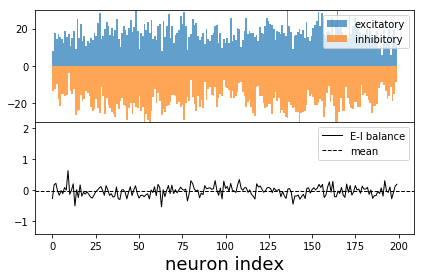

In [36]:
wE = np.array([W[W[:, n]>0, n].sum() for n in neurons])
wI = np.array([W[W[:, n]<0, n].sum() for n in neurons])
in_degree = np.array([len(W[W[:, n]!=0, n]) for n in neurons])
in_degree = np.ma.masked_where(in_degree==0, in_degree)
fig = plt.figure(figsize=(6, 4))
ib = np.ma.divide(wE+wI, in_degree)
grid = grs.GridSpec(2, 1, wspace=0.0, hspace=0.0)
ax1 = plt.Subplot(fig, grid[0])
ax1.bar(neurons, wE, width=1, alpha=0.7, label="excitatory")
ax1.bar(neurons, wI, width=1, alpha=0.7, label="inhibitory")
#ax1.set_ylabel("weight", fontsize=18)
ax1.legend(loc="upper right")
ax1.set_ylim((-30, 30))
ax2 = plt.Subplot(fig, grid[1])
ax2.plot(neurons, ib, color="k", linewidth=1, label="E-I balance")
ax2.axhline(ib.mean(), color="k", linewidth=1, linestyle="dashed", label="mean")
ax2.set_xlabel("neuron index", fontsize=18)
#ax2.set_ylabel("E-I", fontsize=18)
ax2.set_ylim((-1.4, 2.2))
ax2.legend(loc="upper right")
fig.add_subplot(ax1)
fig.add_subplot(ax2)
plt.tight_layout()
plt.savefig("images/ib-hennequin.pdf", bbox_inches="tight")